# Trend Classification with LSTM

### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import warnings
warnings.simplefilter("ignore")

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=14
predict_length = 5
time_period = '6y'

# 1.0 Load data

## 1.1 Load stock data

In [3]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [4]:
traditional_energy_stocks = [ "LNG", "OKE", "BKR", "WMB", "EQT",  "XEC",  "XOM",  "CVX",  "BP",  "OXY",  "COP",  "EOG",  "COG",  "CNQ",  "SLB",  "PTR",  "TOT",  "ENB"]

In [5]:
green_energy_stocks = ["CSIQ", "SPWR", "AQN.TO", "DQ", "HYSR", "PLUG", "SOL", "NEE", "ENPH", "FSLR", "SEDG", "ORA", ]

In [6]:
data = get_data_yf(green_energy_stocks + top_energy, time_period)

[*********************100%***********************]  37 of 37 completed


In [7]:
data.isna().sum().sum()

4650

In [8]:
sum(data.isna().sum(axis=1)>0)

55

In [9]:
data = data.dropna()

In [10]:
sum(data.isna().sum(axis=1)>0)

0

In [11]:
data = process_stock_data_from_yf(data)

In [12]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

## 1.2 Compute technical indicators

In [13]:
all_stock_features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']

In [14]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

## 1.3 Load trends data

In [15]:
filenames = [
    "data climate change adjusted.csv",
    "data greenhouse gas adjusted.csv",
    "data oil adjusted.csv",
    "data renewable adjusted.csv",
    "data carbon tax adjusted.csv",
    "data electric vehicles adjusted.csv",
    "data environmental protection agency adjusted.csv",
    "data fossil fuels adjusted.csv",
    "data fracking adjusted.csv",
    "data global warming adjusted.csv",
]
terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
    "environmental protection agency",
    "fossil fuels",
    "fracking",
    "global warming",
]

In [16]:
climate_trends_data = load_climate_data(filenames, terms)

In [17]:
climate_trends_data.shape

(2278, 11)

<AxesSubplot:xlabel='Date'>

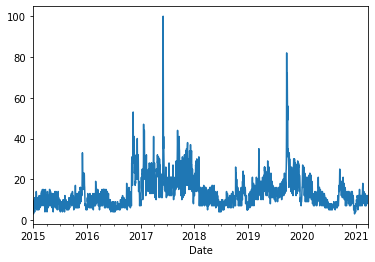

In [18]:
climate_trends_data.set_index('Date')[terms[0]].plot()

### Choose features

In [19]:
chosen_stock_features = ['Close', 'High',
 'Low', 
'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 
#'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 
'WMA', 
'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 
#'DX',
 'PDI', 'NDI', 
'ADX',
 'ROC', 'MACD', 'CCI'
                        ]
# DX and WILLR can cause issues when stock prices don't change, results in lots of nan. 

In [20]:
chosen_trend_terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
#     "environmental protection agency",
    "fossil fuels",
#     "fracking",
    "global warming",
]

# 3.0 Model design

In [61]:
num_features = len(chosen_stock_features) + len(chosen_trend_terms) 

In [62]:
reg = 0.002
drop=0.25

model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))
model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(Flatten())

model.add(Dense(5, activation='relu', activity_regularizer=l2(reg)))
model.add(Dropout(drop))


model.add(Dense(1, activation='sigmoid'))

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 75)            33300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 75)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 14, 30)           

# 2.0 Prepare dataset of many stocks

In [64]:
h = dataset.loc[dataset['Ticker']=='HYSR']

In [65]:
h.isna().sum()

Ticker        0
Date          0
Close         0
High          0
Low           0
Open          0
Volume        0
HH            0
LL            0
AV            0
SMA           0
SD            1
WILLR       268
ATR           0
DMH           0
DML           0
EMA           0
WMA          13
BBHIGH        1
BBLOW         1
PERBHIGH      1
PERBLOW       1
TRIMA        13
RSI          14
DX          621
PDI           0
NDI           0
ADX           6
ROC           0
MACD          0
CCI           1
dtype: int64

In [66]:
# h[h.isna().sum(axis=1)>0][:100]

In [67]:
# dataset[dataset.isna().sum(axis=1)>0]

In [68]:
x_train, y_train, x_valid, y_valid, x_test, y_test = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           green_energy_stocks + top_energy,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [69]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (25388, 14, 35)
y_train: (25388,)
x_valid: (8399, 14, 35)
y_valid (8399,)
x_test: (8436, 14, 35)
y_test (8436,)


## 2.1 Train on many stocks

In [70]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [71]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [72]:
history1 = model.fit(x_train, 
                     y_train, 
                     epochs=15, 
                     validation_data=(x_valid, y_valid), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/15
397/397 [==============================] - 16s 29ms/step - loss: 0.7553 - accuracy: 0.5136 - val_loss: 0.6941 - val_accuracy: 0.5595
Epoch 2/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6889 - accuracy: 0.5373 - val_loss: 0.6983 - val_accuracy: 0.5178
Epoch 3/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6841 - accuracy: 0.5493 - val_loss: 0.7023 - val_accuracy: 0.5191
Epoch 4/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6793 - accuracy: 0.5661 - val_loss: 0.6950 - val_accuracy: 0.5246
Epoch 5/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6752 - accuracy: 0.5768 - val_loss: 0.7102 - val_accuracy: 0.5054
Epoch 6/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6656 - accuracy: 0.5974 - val_loss: 0.7475 - val_accuracy: 0.4717
Epoch 7/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6613 - accuracy: 0.6046 - val_loss: 0.7880 - val_accuracy: 0.480

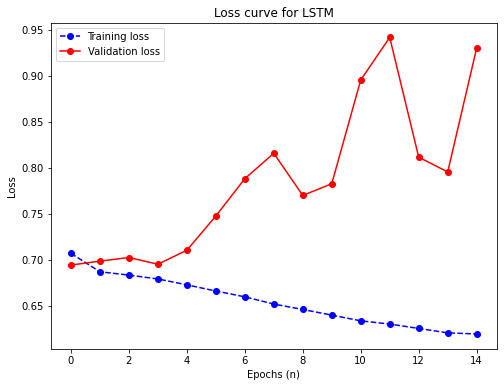

In [73]:
plot_loss(history1)

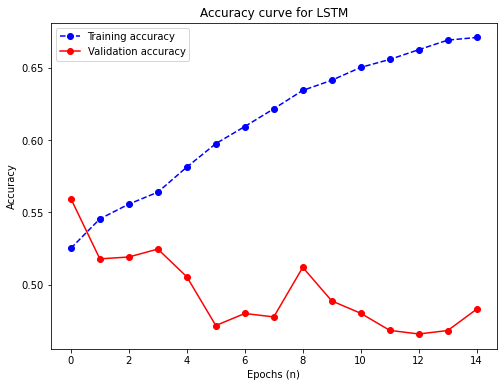

In [74]:
plot_acc(history1)

## 2.2 Performance of model

In [75]:
performance_stats(model, x_train, y_train)

Upward ratio: 50.32%
Mean prediction: 51.59%
Predicted upward ratio: 57.09%
Accuracy: 69.15%


In [76]:
performance_stats(model, x_valid, y_valid)

Upward ratio: 51.70%
Mean prediction: 45.47%
Predicted upward ratio: 32.12%
Accuracy: 48.30%


In [77]:
performance_stats(model, x_test, y_test)

Upward ratio: 50.26%
Mean prediction: 69.97%
Predicted upward ratio: 66.64%
Accuracy: 52.92%


# 3.0 Prepare data for less stocks

In [78]:
x_train2, y_train2, x_valid2, y_valid2, x_test2, y_test2 = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           green_energy_stocks,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [79]:
print("x_train: {}".format(x_train2.shape))
print("y_train: {}".format(y_train2.shape))
print("x_valid: {}".format(x_valid2.shape))
print("y_valid {}".format(y_valid2.shape))
print("x_test: {}".format(x_test2.shape))
print("y_test {}".format(y_test2.shape))

x_train: (8213, 14, 35)
y_train: (8213,)
x_valid: (2724, 14, 35)
y_valid (2724,)
x_test: (2736, 14, 35)
y_test (2736,)


## 3.1 Train model on less stocks

In [80]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [81]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [83]:
history2 = model.fit(x_train2, 
                     y_train2, 
                     epochs=15, 
                     validation_data=(x_valid2, y_valid2), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/15
129/129 [==============================] - 13s 61ms/step - loss: 0.6430 - accuracy: 0.6408 - val_loss: 0.8244 - val_accuracy: 0.5132
Epoch 2/15
129/129 [==============================] - 2s 16ms/step - loss: 0.6398 - accuracy: 0.6386 - val_loss: 0.8362 - val_accuracy: 0.5117
Epoch 3/15
129/129 [==============================] - 2s 15ms/step - loss: 0.6382 - accuracy: 0.6418 - val_loss: 1.0661 - val_accuracy: 0.5033
Epoch 4/15
129/129 [==============================] - 2s 15ms/step - loss: 0.6266 - accuracy: 0.6505 - val_loss: 0.9706 - val_accuracy: 0.5044
Epoch 5/15
129/129 [==============================] - 2s 15ms/step - loss: 0.6373 - accuracy: 0.6487 - val_loss: 0.9298 - val_accuracy: 0.5128
Epoch 6/15
129/129 [==============================] - 2s 16ms/step - loss: 0.6329 - accuracy: 0.6469 - val_loss: 0.9144 - val_accuracy: 0.5268
Epoch 7/15
129/129 [==============================] - 2s 15ms/step - loss: 0.6236 - accuracy: 0.6598 - val_loss: 0.8729 - val_accuracy: 0.524

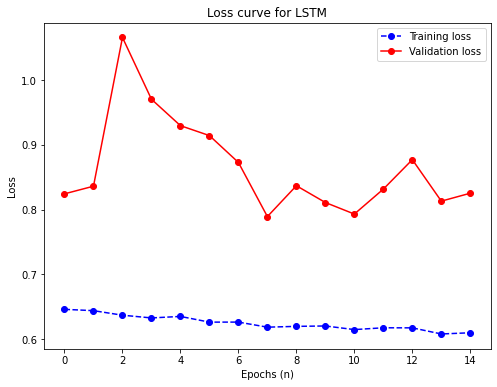

In [84]:
plot_loss(history2)

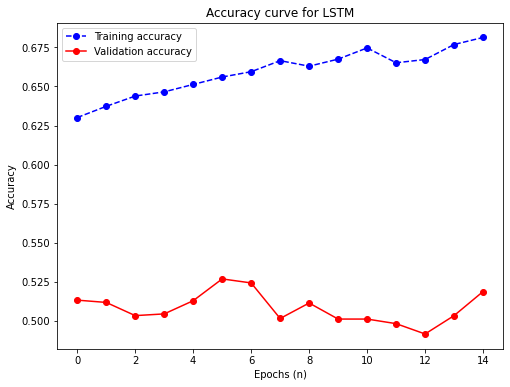

In [85]:
plot_acc(history2)

## 3.2 Performance of model

In [86]:
performance_stats(model, x_train2, y_train2)

Upward ratio: 47.61%
Mean prediction: 50.05%
Predicted upward ratio: 52.58%
Accuracy: 69.76%


In [87]:
performance_stats(model, x_valid2, y_valid2)

Upward ratio: 48.46%
Mean prediction: 39.79%
Predicted upward ratio: 18.98%
Accuracy: 51.87%


In [88]:
performance_stats(model, x_test2, y_test2)

Upward ratio: 55.23%
Mean prediction: 55.14%
Predicted upward ratio: 51.46%
Accuracy: 50.77%


# 4.0 Prepare data for one stock

In [89]:
green_energy_stocks[0]

'CSIQ'

In [90]:
x_train3, y_train3, x_valid3, y_valid3, x_test3, y_test3 = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           [green_energy_stocks[0]],
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [91]:
print("x_train: {}".format(x_train3.shape))
print("y_train: {}".format(y_train3.shape))
print("x_valid: {}".format(x_valid3.shape))
print("y_valid {}".format(y_valid3.shape))
print("x_test: {}".format(x_test3.shape))
print("y_test {}".format(y_test3.shape))

x_train: (687, 14, 35)
y_train: (687,)
x_valid: (227, 14, 35)
y_valid (227,)
x_test: (228, 14, 35)
y_test (228,)


## 4.1 Train model on less stocks

In [92]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [93]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [94]:
tensorboard = TensorBoard(log_dir='logs/{}_3'.format(time_stamp))

In [95]:
history3 = model.fit(x_train3, 
                     y_train3, 
                     epochs=5, 
                     validation_data=(x_valid3, y_valid3), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/5
11/11 [==============================] - 11s 620ms/step - loss: 0.5265 - accuracy: 0.7709 - val_loss: 0.9735 - val_accuracy: 0.4714
Epoch 2/5
11/11 [==============================] - 0s 18ms/step - loss: 0.4792 - accuracy: 0.8001 - val_loss: 0.9577 - val_accuracy: 0.4890
Epoch 3/5
11/11 [==============================] - 0s 18ms/step - loss: 0.4628 - accuracy: 0.8026 - val_loss: 1.0086 - val_accuracy: 0.5022
Epoch 4/5
11/11 [==============================] - 0s 18ms/step - loss: 0.4645 - accuracy: 0.8127 - val_loss: 0.9826 - val_accuracy: 0.4758
Epoch 5/5
11/11 [==============================] - 0s 18ms/step - loss: 0.4833 - accuracy: 0.7747 - val_loss: 0.9874 - val_accuracy: 0.4934


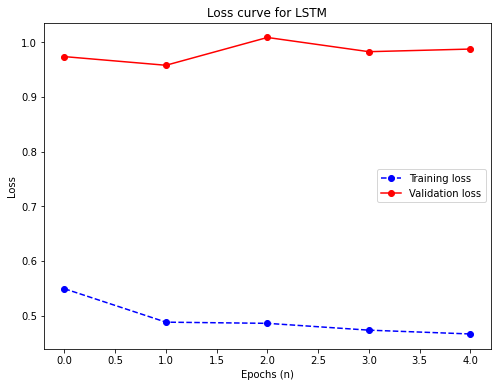

In [96]:
plot_loss(history3)

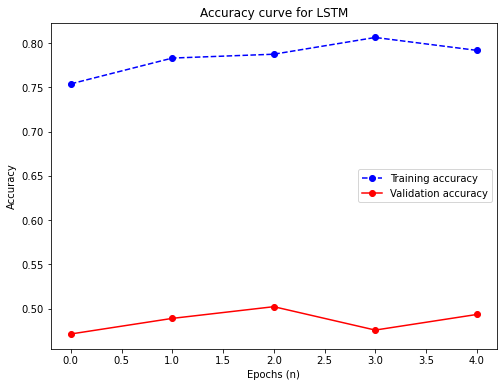

In [97]:
plot_acc(history3)

## 4.2 Performance of model

In [98]:
performance_stats(model, x_train3, y_train3)

Upward ratio: 50.22%
Mean prediction: 50.68%
Predicted upward ratio: 50.95%
Accuracy: 84.13%


In [99]:
performance_stats(model, x_valid3, y_valid3)

Upward ratio: 56.83%
Mean prediction: 41.44%
Predicted upward ratio: 21.15%
Accuracy: 49.34%


In [100]:
performance_stats(model, x_test3, y_test3)

Upward ratio: 54.82%
Mean prediction: 69.96%
Predicted upward ratio: 65.35%
Accuracy: 60.53%
